In [1]:
library(cowplot)
library(tidyverse)

palette <- c('HSIC Lasso' = '#c994c7', 'HSIC Lasso, B = 50' = '#df65b0',
             'HSIC Lasso, B = 20' = '#e7298a', 'HSIC Lasso, B = 10' = '#ce1256',
             'HSIC Lasso, B = 5' = '#67001f',
             'LARS' = '#2171b5', 'mRMR' = '#238443')
methods <- c('HSIC Lasso', 'HSIC Lasso, B = 50',
             'HSIC Lasso, B = 40','HSIC Lasso, B = 30',
             'HSIC Lasso, B = 20','HSIC Lasso, B = 10',
             'HSIC Lasso, B = 5', 'mRMR', 'LARS')

parse_deltatime <- function(column) {
    
    parse_subfield <- function (x) {
        if (grepl('ms', x)) {
            x <- gsub('ms', '', x) %>% as.numeric
            x <- x / 1000
        } else if (grepl('s', x)) {
            x <- gsub('s', '', x) %>% as.numeric
        } else if (grepl('m', x)) {
            x <- gsub('m', '', x) %>% as.numeric
            x <- x * 60
        } else if (grepl('h', x)) {
            x <- gsub('h', '', x) %>% as.numeric
            x <- x * 3600
        } else {
            x <- NA
        }

        return(x)
        
    }
    
    strsplit(column, ' ') %>% lapply(function(x) lapply(x, parse_subfield) %>% unlist) %>% lapply(sum) %>% unlist
   
}
                                     
parse_memory <- function(column) {
    
    parse_subfield <- function (x) {
        if (grepl('MB', x)) {
            x <- gsub(' MB', '', x) %>% as.numeric
        } else if (grepl(' GB', x)) {
            x <- gsub(' GB', '', x) %>% as.numeric
            x <- x * 1000
        } else {
            x <- NA
        }

        return(x)
        
    }
    
    lapply(column, parse_subfield) %>% unlist
   
}
                                     
read_trace <- function(tracefile) {
    
    read_tsv(tracefile, col_types = 'cccccccccccccc') %>%
        mutate(time_s = parse_deltatime(realtime),
               memory_mb = parse_memory(vmem),
               task = gsub(' .+', '', name) %>% gsub('run_', '', .) %>% toupper,
               causal = gsub('.+[^0-9] \\(', '', name) %>% gsub(',.+', '', .),
               B = gsub('.+ B = ', '', name) %>% gsub(' .+', '', .)) %>% 
        filter(task %in% c('HSIC_LASSO', 'LARS', 'MRMR')) %>%
        mutate(task = ifelse(task == 'HSIC_LASSO', 'HSIC Lasso', task),
               task = ifelse(task == 'MRMR', 'mRMR', task),
               task = ifelse(task == 'HSIC Lasso' & B != '0', paste0(task, ', B = ', B), task),
               task = factor(task, levels = methods))
    
}

Loading required package: ggplot2

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  1.4.2     ✔ purrr   0.2.5
✔ tidyr   0.8.2     ✔ dplyr   0.7.8
✔ readr   1.2.1     ✔ stringr 1.3.1
✔ tibble  1.4.2     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()   masks stats::filter()
✖ purrr::flatten()  masks jsonlite::flatten()
✖ cowplot::ggsave() masks ggplot2::ggsave()
✖ dplyr::lag()      masks stats::lag()


In [2]:
runtime <- read_trace('../results/benchmark/trace.txt')
memory <- read_trace('../results/resources/trace.txt')

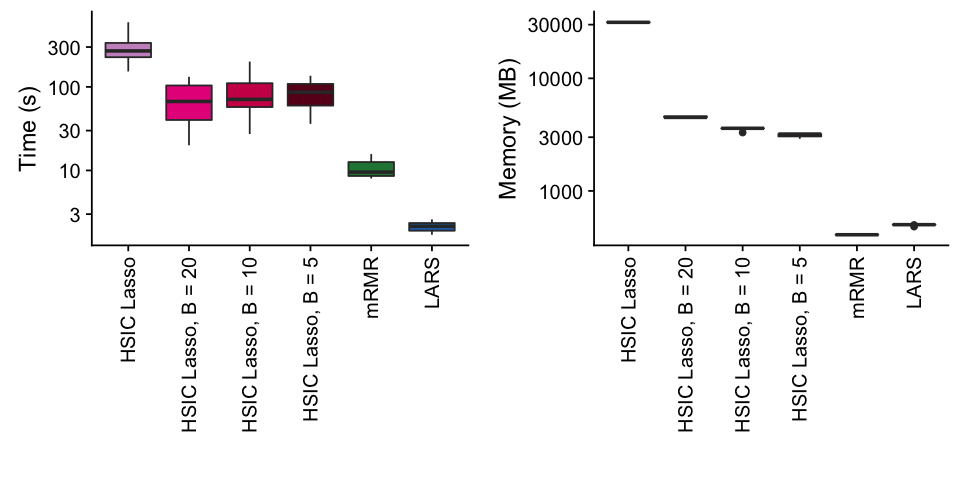

In [3]:
runtime_plt <- ggplot(runtime, aes(x = task, y = time_s, fill = task)) +
        geom_boxplot() +
        scale_y_log10() +
        labs(y = 'Time (s)', x = '') +
        scale_fill_manual(values = palette) +
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5),
              legend.position = 'none')

memory_plt <- ggplot(memory, aes(x = task, y = memory_mb, fill = task)) +
        geom_boxplot() +
        scale_y_log10() +
        labs(y = 'Memory (MB)', x = '') +
        scale_fill_manual(values = palette) +
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5),
              legend.position = 'none')

options(repr.plot.width=8, repr.plot.height=4)
plot_grid(runtime_plt, memory_plt)